In [41]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver import Keys, ActionChains
from random import randint
import matplotlib.pyplot as plt
import pandas as pd
import time
import re

from log import logging

In [42]:
driver=webdriver.Chrome()

driver.get("https://www.aviasales.by/")

In [43]:
@logging
def open_window_popular_countries():
    time.sleep(randint(10, 25)/10)
    ActionChains(driver)\
        .key_down(Keys.PAGE_DOWN)\
        .perform()
    time.sleep(0.1)
    clickable_element = WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable((By.XPATH, '//*[@id="selene"]/div/div[2]/div/noindex/div/div/div[3]/div/div[2]/button'))
    )

    clickable_element.click()

@logging
def get_all_popular_countries():
    time.sleep(randint(10, 25)/10)
    countries = WebDriverWait(driver, 10).until(
        EC.presence_of_all_elements_located((By.CLASS_NAME, "s__MvVzMn1eHc7dL22r"))
    )
    return countries

@logging
def open_window_all_cities():
    time.sleep(randint(10, 25)/10)
    clickable_element = WebDriverWait(driver, 3).until(
        EC.element_to_be_clickable((By.XPATH, '//*[@id="selene"]/div/div[2]/div/section/div/div/div[2]/button'))
    )

    clickable_element.click()

In [44]:
#функция, чтобь обрезать строку с ценой
@logging
def extract_price(text):
    if text == "None":
        return text
    #удаляем все пробелы, включая неразрывные
    cleaned = re.sub(r'[\s\u00a0\u202f]+', '', text)
    #ищем полное число
    match = re.search(r'\d+', cleaned)
    return int(match.group()) if match else None

@logging
def get_info_about_cities_price_in_window(id, to_country):
    time.sleep(randint(10, 25)/10)
    try:#указана ли цена
        price = WebDriverWait(driver, 0.1).until(
            EC.presence_of_all_elements_located((By.CSS_SELECTOR, f"#avs-modal-container > div > div > div > div > div.s__GBMeiZmmPzUAgz03 > ul > li:nth-child({id}) > button > figure > div > div.s__d1vMY1ioficx5faN.s__W76aiHDeNw2ybh8S > div > div"))
        )[0].text
    except Exception:#если не указана, то None
        price = 'None'
    city = WebDriverWait(driver, 1).until(
        EC.presence_of_all_elements_located((By.CSS_SELECTOR, f'#avs-modal-container > div > div > div > div > div.s__GBMeiZmmPzUAgz03 > ul > li:nth-child({id}) > button > figure > figcaption'))
    )[0].text
    return {'Откуда': 'Беларусь', 'Город отправления': 'Минск', 'Куда': to_country, 'Город назначения': city, 'Цена': extract_price(price)}

@logging
def get_info_about_cities_price_not_in_window(id, to_country):
    time.sleep(randint(10, 25)/10)
    try: 
        price = WebDriverWait(driver, 0.1).until(
            EC.presence_of_all_elements_located((By.CSS_SELECTOR, f"#selene > div > div.s__b_QNEUFO8oMDaXCk > div > section > div > div > div > ul > li:nth-child({id}) > button > figure > div > div.s__d1vMY1ioficx5faN.s__W76aiHDeNw2ybh8S > div > div"))
        )[0].text
    except Exception:
        price = 'None'
    city = WebDriverWait(driver, 1).until(
        EC.presence_of_all_elements_located((By.CSS_SELECTOR, f'#selene > div > div.s__b_QNEUFO8oMDaXCk > div > section > div > div > div > ul > li:nth-child({id}) > button > figure > figcaption'))
    )[0].text
    return {'Откуда': 'Беларусь', 'Город отправления': 'Минск', 'Куда': to_country, 'Город назначения': city, 'Цена': extract_price(price)}

In [45]:
open_window_popular_countries()
len_list_with_countries = len(get_all_popular_countries()) - 1

count = 0
list_to_pandas = []

In [46]:
while count < len_list_with_countries:

    country = WebDriverWait(driver, 1).until(
        EC.presence_of_all_elements_located((By.CSS_SELECTOR, f'#avs-modal-container > div > div > div > div > div.s__GBMeiZmmPzUAgz03 > ul > li:nth-child({count + 1}) > button > figure > figcaption > div.s__aCyCrtDnhqcYxb6Y.s__czWTXrMeAzlXSjEV.s__wVEIDI5_AjIKLqau'))
    )[0].text

    buttons = get_all_popular_countries()
    button = buttons[count]#выбираем нужную страну нужную страну
    count += 1
    driver.execute_script("arguments[0].click();", button) #кликаем на нее

    try:#не у всех стран есть окно с городами
        open_window_all_cities()
        time.sleep(0.5)
        #прокручиваем страницу вниз, чтобы собрать все города
        ActionChains(driver)\
            .key_down(Keys.PAGE_DOWN)\
            .perform()
        time.sleep(1)

        #узнаем кол-во городов в стране
        list_with_cities = WebDriverWait(driver, 10).until(
            EC.presence_of_all_elements_located((By.CSS_SELECTOR, '#avs-modal-container > div > div > div > div > div.s__GBMeiZmmPzUAgz03 > ul > li'))
        )
        count_cities_on_page = len(list_with_cities)

        print(country)
        print(count_cities_on_page)

        #цикл, чтобы пройти по всем городам на странице
        for i in range(count_cities_on_page):
            info_about_city = get_info_about_cities_price_in_window(i + 1, country)
            list_to_pandas.append(info_about_city)

        
    except Exception:#если окно не открывается
        #узнаем кол-во городов в стране
        list_with_cities = WebDriverWait(driver, 10).until(
            EC.presence_of_all_elements_located((By.CLASS_NAME, 's__tfDG4AZtfoU6zqkR'))
        )
        count_cities_on_page = len(list_with_cities)
        print(country)
        print(count_cities_on_page)

        #цикл, чтобы пройти по всем городам на странице
        for i in range(count_cities_on_page):
            info_about_city = get_info_about_cities_price_not_in_window(i + 1, country)
            list_to_pandas.append(info_about_city)
        

    #перезаход на сайт, чтобы взять новую страну
    time.sleep(randint(10, 25)/10)
    driver.get("https://www.aviasales.by/?params=MSQ1")
    open_window_popular_countries()

Россия
241
Беларусь
6
Турция
52
Китай
215
Грузия
3
Таиланд
33
ОАЭ
6
Вьетнам
22
Италия
41
Испания
56
Испания
56
Узбекистан
15
Польша
14
Польша
14
Азербайджан
6
Литва
3
Индия
115
Шри‑Ланка
10
Армения
2
Германия
28
Япония
72
США
494
Франция
59
Индонезия
87
Северный Кипр
1
Малайзия
35
Мальдивы
8
Туркменистан
4
Кыргызстан
11
Кипр
2


TimeoutException: Message: 


In [48]:
count
len_list_with_countries

59

In [14]:
df = pd.DataFrame(list_to_pandas)
df.to_csv('all_stats.csv')

In [36]:
df = pd.read_csv("all_stats.csv")

In [37]:
#преобразование столбца 'Цена' в числовой формат
df['Цена'] = pd.to_numeric(df['Цена'], errors='coerce')

#удаление строк, где цена отсутствует (None → NaN)
df_clean = df.dropna(subset=['Цена'])
df_clean = df_clean.drop(columns=['Unnamed: 0'])

In [38]:
df_clean.to_csv('all_stats_clean.csv')

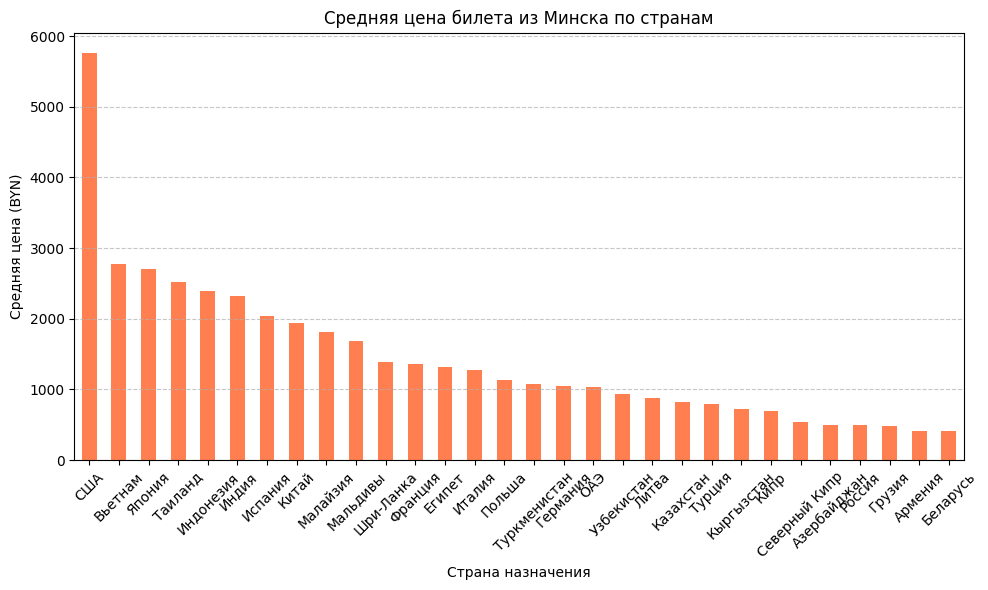

In [39]:
#группировка по странам
country_avg = df_clean.groupby('Куда')['Цена'].mean().sort_values(ascending=False)


plt.figure(figsize=(10, 6))
country_avg.plot(kind='bar', color='coral')
plt.title('Средняя цена билета из Минска по странам')
plt.ylabel('Средняя цена (BYN)')
plt.xlabel('Страна назначения')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

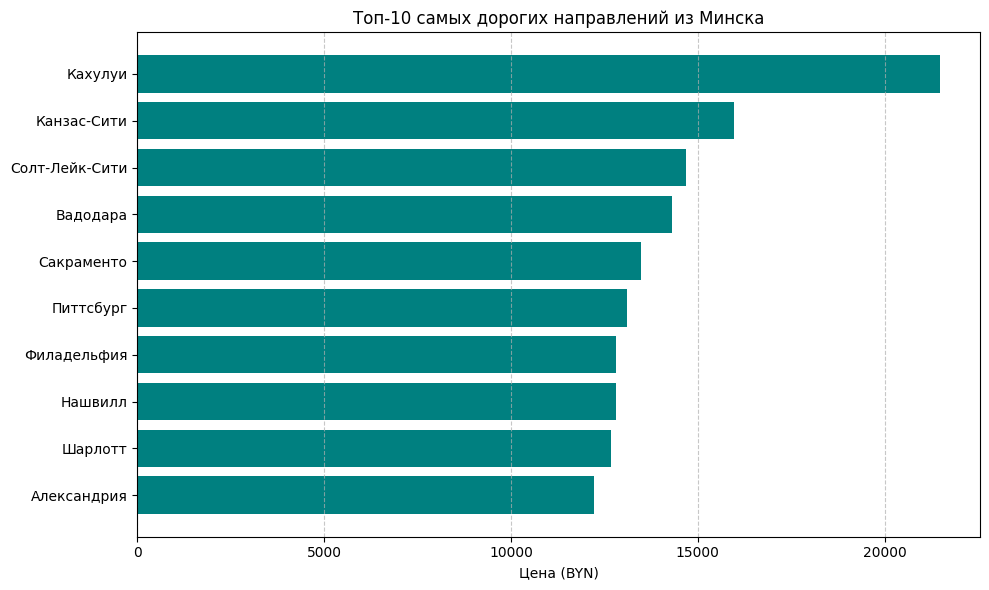

In [40]:
top10 = df_clean.sort_values(by='Цена', ascending=False).head(10)#топ 10 стран

#график
plt.figure(figsize=(10, 6))
plt.barh(top10['Город назначения'], top10['Цена'], color='teal')
plt.title('Топ-10 самых дорогих направлений из Минска')
plt.xlabel('Цена (BYN)')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()